<a href="https://colab.research.google.com/github/pyagoubi/Motorcycle-data/blob/main/Motorcycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math


In [106]:
data = pd.read_csv('/content/drive/MyDrive/upwork1/DATA1.TXT', sep=',')

In [107]:
data['Gx clean'] = data['Gx']-data['Gx Cal']
data['Gy clean'] = data['Gy']-data['Gy Cal']

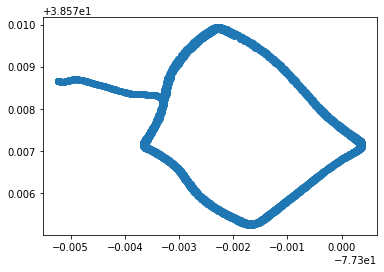

In [ ]:
#Display map
plt.scatter(x=data['Longitude'], y=data['Latitude'])

In [ ]:
#calculate the distance on Longitude/ Latitude plane assuming 2D plane

data['Lat diff5'] = data.groupby(['Lap Number']).transform(lambda x: x.diff(5))['Latitude']
data['Long diff5'] = data.groupby(['Lap Number']).transform(lambda x: x.diff(5))['Longitude']

data[['Lat diff5','Long diff5']].fillna(0, inplace = True)

data['Lat diff-5'] = data.groupby(['Lap Number']).transform(lambda x: x.shift(-5) -x )['Latitude']
data['Lon diff-5'] = data.groupby(['Lap Number']).transform(lambda x: x.shift(-5) -x )['Longitude']

<ipython-input-77-0f13344311e4>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  data['Lat diff5'] = data.groupby(['Lap Number']).transform(lambda x: x.diff(5))['Latitude']
<ipython-input-77-0f13344311e4>:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  data['Long diff5'] = data.groupby(['Lap Number']).transform(lambda x: x.diff(5))['Longitude']


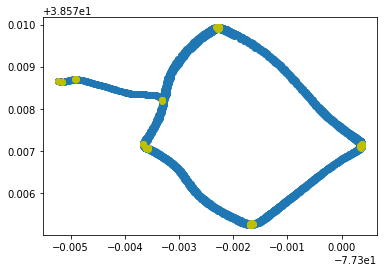

In [ ]:
#flag corner rows

data['corner'] = 0
data.loc[((data['Lat diff-5'] > 0) & (data['Lat diff5'] < 0))| ((data['Lat diff-5'] < 0) & (data['Lat diff5'] > 0)) 
| ((data['Lon diff-5'] > 0) & (data['Long diff5'] < 0))
| ((data['Lon diff-5'] < 0) & (data['Long diff5'] >= 0)), 'corner'] = 1 


plt.scatter(x=data['Longitude'], y=data['Latitude'])
plt.scatter(x=data.loc[data['corner'] == 1, 'Longitude'], y=data.loc[data['corner'] == 1,'Latitude'], color = 'y')

In [ ]:
#check if we got all laps
data.loc[data['c']==1, 'Lap Number'].unique()

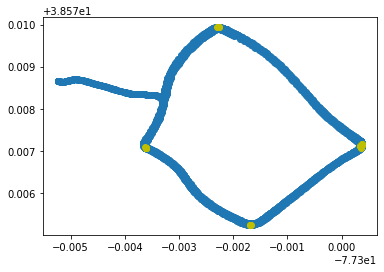

In [ ]:
#Points on the left can be eliminated by setting Gy-value (absolute) to >11, but then we lose data from the first lap

plt.scatter(x=data['Longitude'], y=data['Latitude'])
plt.scatter(x=data.loc[(data['corner'] == 1) & (data['Gy clean'].abs() >11), 'Longitude'], y=data.loc[(data['corner'] == 1) 
& (data['Gy clean'].abs() >11),'Latitude'], color = 'y')

In [4]:
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [5]:
coords = data[['Longitude', 'Latitude']].to_numpy()

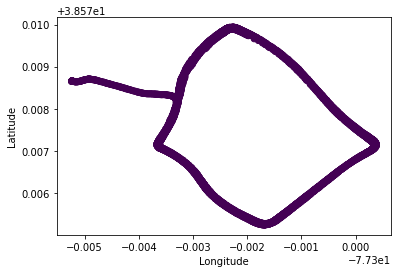

In [43]:
model = DBSCAN(eps=0.0003, min_samples=30)
model.fit(coords)
labels = model.labels_

plt.scatter(data['Longitude'], data['Latitude'], c=labels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


corners = []
for i in range(1, len(labels)):
    if labels[i] != labels[i-1]:
        corners.append(i)

In [53]:
A = (12.92473, 77.6183)
B = (12.92512, 77.61923)
C = (12.92541, 77.61985)

# Convert the points to numpy latitude/longitude radians space
a = np.radians(np.array(A))
b = np.radians(np.array(B))
c = np.radians(np.array(C))

print(a,b,c)

[0.22557909 1.35469489] [0.2255859  1.35471113] [0.22559096 1.35472195]


In [63]:
temp_df['one'].shift(2)

0         NaN
1         NaN
2    12.92473
Name: one, dtype: float64

In [108]:
shift_parameter = 20


# Convert the points to numpy latitude/longitude radians space

data['Lat converted'] = np.radians(data['Latitude'])
data['Lon converted'] = np.radians(data['Longitude'])

#past reference point
data['Lat before'] = data['Lat converted'].shift(shift_parameter)
data['Lon before'] = data['Lon converted'].shift(shift_parameter)

#future reference point
data['Lat after'] = data['Lat converted'].shift(-shift_parameter)
data['Lon after'] = data['Lon converted'].shift(-shift_parameter)


# Vectors in latitude/longitude space
data['vector prev'] = (np.array(data[['Lat converted', 'Lon converted']]) - np.array(data[['Lat before', 'Lon before']])).tolist()
data['vector past'] = (np.array(data[['Lat converted', 'Lon converted']]) - np.array(data[['Lat after', 'Lon after']])).tolist()

In [127]:
np.degrees(math.acos(np.dot(data['vector prev'][30], data['vector past'][30]) / (np.linalg.norm(data['vector prev'][30]) * np.linalg.norm(data['vector past'][30]))))

179.72609439156923

In [131]:
for i in len(data):
  print(i)

0
4202
